In [48]:
% matplotlib inline
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt

from math import isinf

Visualizing example dataset for outlier detection.


[0, 30, 0, 30]

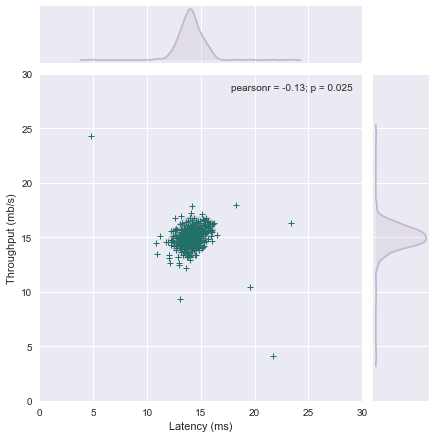

In [66]:
print('Visualizing example dataset for outlier detection.')

#  The following command loads the dataset. You should now have the
#  variables X, Xval, yval in your environment
data = scipy.io.loadmat('ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].flatten()

#  Visualize the example dataset
# plt.plot(X[:, 0], X[:, 1], 'bx')
g = sns.jointplot(x=X[:, 0], y=X[:, 1], data=X, kind="kde", color="#C4B7D0")
g.plot_joint(plt.scatter, c="#207068", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

In [73]:
def multivariateGaussian(X, mu, Sigma2):
    """Computes the probability
    density function of the examples X under the multivariate gaussian
    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
    treated as the covariance matrix. If Sigma2 is a vector, it is treated
    as the \sigma^2 values of the variances in each dimension (a diagonal
    covariance matrix)
    """
    k = len(mu)

    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5) * \
        np.exp(-0.5 * np.sum(X.dot(np.linalg.pinv(Sigma2))*X, axis=1))

    return p

def visualizeFit(X, mu, sigma2):
    """
    This visualization shows you the
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    fig, ax = plt.subplots(figsize=[8,8])
    
    n = np.linspace(0,35,71)
    X1 = np.meshgrid(n,n)
    Z = multivariateGaussian(np.column_stack((X1[0].T.flatten(), X1[1].T.flatten())),mu,sigma2)
    Z = Z.reshape(X1[0].shape)

    ax.plot(X[:, 0], X[:, 1],'bo')
    # Do not plot if there are infinities
    if not isinf(np.sum(Z)):
        ax.contour(X1[0], X1[1], Z, 10.0**np.arange(-20, 0, 3).T)

def estimateGaussian(X):
    """
    This function estimates the parameters of a
    Gaussian distribution using the data in X
      The input X is the dataset with each n-dimensional data point in one row
      The output is an n-dimensional vector mu, the mean of the data set
      and the variances sigma^2, an n x 1 vector
    """
    m = len(X)

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the mean of the data and the variances
    #               In particular, mu(i) should contain the mean of
    #               the data for the i-th feature and sigma2(i)
    #               should contain variance of the i-th feature.
    #
# =============================================================
    mu = []
    sigma2 = []
    for col_num in range(0,X.shape[1]):
        feature_col = X[:, col_num]
        mu.append(feature_col.mean())
        sigma2.append(np.var(feature_col))
    return np.array(mu), np.array(sigma2)

Visualizing Gaussian fit.


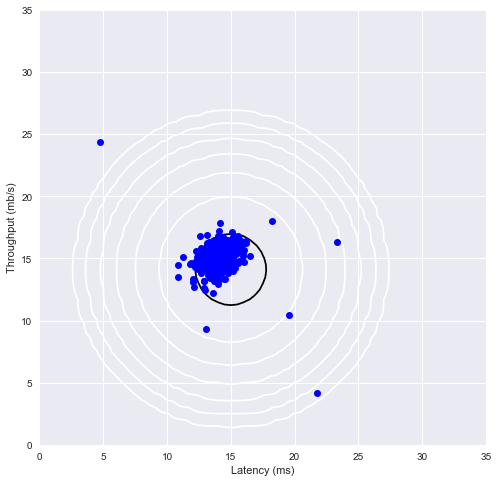

In [88]:
print('Visualizing Gaussian fit.')

#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

In [110]:
from sklearn.metrics import f1_score

def selectThreshold(yval, pval):
    """
    finds the best
    threshold to use for selecting outliers based on the results from a
    validation set (pval) and the ground truth (yval).
    """

    bestEpsilon = 0
    bestF1 = 0

    stepsize = (np.max(pval) - np.min(pval)) / 1000.0
    for epsilon in np.arange(np.min(pval),np.max(pval), stepsize):
        # ====================== YOUR CODE HERE ======================
        # Instructions: Compute the F1 score of choosing epsilon as the
        #               threshold and place the value in F1. The code at the
        #               end of the loop will compare the F1 score for this
        #               choice of epsilon and set it to be the best epsilon if
        #               it is better than the current choice of epsilon.
        #
        # Note: You can use predictions = (pval < epsilon) to get a binary vector
        #       of 0's and 1's of the outlier predictions
        pred = (pval < epsilon).astype('int')
        F1 = f1_score(yval, pred)
        # =============================================================
        if F1 > bestF1:
           bestF1 = F1
           bestEpsilon = epsilon

    return bestEpsilon, bestF1


c:\users\matka\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)


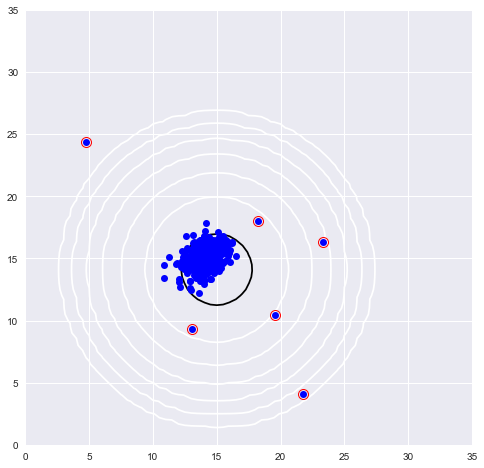

In [111]:

pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')

#  Find the outliers in the training set and plot the
outliers = np.where(p < epsilon, True, False)

#  Draw a red circle around those outliers
visualizeFit(X,  mu, sigma2)
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', lw=2, markersize=10, fillstyle='none', markeredgewidth=1)
# show()

In [112]:
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
data = scipy.io.loadmat('ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].flatten()

#  Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('# Outliers found: %d' % sum(p < epsilon))
print('   (you should see a value epsilon of about 1.38e-18)')

c:\users\matka\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Outliers found: 117
   (you should see a value epsilon of about 1.38e-18)


# Recomender systems

Loading movie ratings dataset.
Average rating for movie 1 (Toy Story): 3.878319 / 5


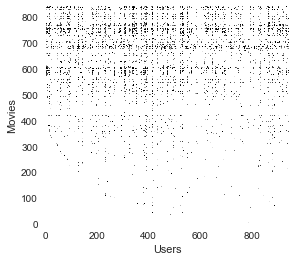

In [113]:
print('Loading movie ratings dataset.')

#  Load data
data = scipy.io.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R'].astype(bool)
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' % np.mean(Y[0, R[0, :]]))

#  We can "visualize" the ratings matrix by plotting it with imagesc

plt.figure()
plt.imshow(Y, aspect='equal', origin='upper', extent=(0, Y.shape[1], 0, Y.shape[0]/2.0))
plt.ylabel('Movies')
plt.xlabel('Users')
